# Ringdown analyses

## Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pystan
import seaborn as sns
import utils
import arviz as az
import corner

sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
plt.rcParams["text.usetex"] = "true"
numpy.random.seed(1234)

## Preprocessing

Set some global settings:

In [153]:
test = 'rin'

# Input directory for individual samples from each run
input_paths_dict = {
    #'pyring': '/home/max.isi/papers/o3a-cbc-tgr/release/rin/{event}/rin_{event}_pyring_{par}.dat.gz',
    #'pseob': '/home/max.isi/papers/o3a-cbc-tgr/release/rin/{event}/rin_{event}_pseobnrv4hm_{par}.dat.gz',
    'pseob': '/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{event}/rin_{event}_pseobnrv4hm_{par}.dat.gz',
}

events_dict = {
    #'pyring': None,
    #'pseob': ['S190519bj', 'S190521r', 'S190910s']
    #'pseob': ['GW150914', 'GW170104', 'GW170729','GW170814','GW170823','S190519bj','S190521r', 'S190910s']
    #'pseob': ['GW150914', 'GW170104', 'GW170729','S190519bj','S190521r', 'S190910s']
    'pseob': ['GW150914', 'GW170104', 'S190519bj','S190521r', 'S190910s']

}

params_dict = {
    #'pyring': ['domega_221'],
    'pseob': ['domega_220', 'dtau_220'],
}

LOAD_CACHE = False
FORCE_LOAD_DATA = True

## Hierarchical combination

If previous results not found in disk, load `stan` model and fit it, looping over both ringdown analyses (`pyring` and `pseob`), whose parameters and events are defined above.

In [154]:
fits_dict = {}

for run, input_path in input_paths_dict.items():
    print("Fitting run: %s\n-------------" % run)
    
    # Names of parameters (used to load files)
    params = params_dict[run]
    
    # Define cache path and create dir if needed
    cache_path = os.path.join('../cache/', test, run, '{par}_{hyper}.txt.gz')
    cache_dir = os.path.dirname(cache_path)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
        print("Created: %r" % cache_dir)

    # Attempt to load data and/or cached fit results
    data, fits, paths = utils.load_data_fits(params, input_path,
                                             cache=cache_path if LOAD_CACHE else '',
                                             force_load_data=FORCE_LOAD_DATA)
    for param, samp_dict in data.items():
        print("Loaded %r samples from %i events." % (param, len(samp_dict)))
    
    loaded_cache = all([p in fits for p in params])
    
    # purge parameters for which no data was found
    params = [p for p in params if len(data[p])>0]
    for p in data.keys():
        data = {k: v for k,v in data.items() if p in params}
        fits = {k: v for k,v in fits.items() if p in params}
        paths = {k: v for k,v in paths.items() if p in params}

    # only some events are good for combining, remove the rest
    if events_dict[run] is not None:
        for p in data.keys():
            for d in [data, paths]:
                if p in d:
                    d[p] = {k: v for k,v in d[p].items() if k in events_dict[run]}
            print("Kept %r samples from %i events." % (p, len(data[p])))

    # If population fit not pre-loaded from disk, load Stan model and fit it.
    try:
        if model is None and not all([p in fits for p in params]):
            model = pystan.StanModel(file='hierGRtest.stan')
    except NameError:
        if not all([p in fits for p in params]):
            model = pystan.StanModel(file='hierGRtest.stan')
        else:
            # no need to load model because fits cached
            model = None
            
    # Fit it! (only if needed: `fit_all` checks whether fit already exists)
    fits = utils.fit_all(data, fits=fits, model=model, cache=cache_path)
    if cache_path and not loaded_cache:
        utils.save_cache(fits, cache_path, paths=paths)
    fits_dict[run] = fits

Fitting run: pseob
-------------
Loaded 'domega_220' samples from 8 events.
Loaded 'dtau_220' samples from 8 events.
Kept 'domega_220' samples from 5 events.
Kept 'dtau_220' samples from 5 events.


/Users/richardbrito/Desktop/Projects/spinqnm/hierarchical_scripts/utils.py:182: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  chi_samples = np.array(list(chi_samples_dict.values()))


Cached domega_220
Cached dtau_220
Events logged: '../cache/rin/pseob/events.json'


## Summary stats

In [155]:
for run, fits in fits_dict.items():
    print('##################################')
    print('Run: %s' % run)
    hyper_ci_dict = utils.get_hyper_summary(fits)
    print()

##################################
Run: pseob
Hyperparameter constraints (90% CL)
----------------------------------
domega_220 (x1)
	mu:	0.02 +0.06 -0.06  [0.12]
	sigma: < 0.11
dtau_220 (x1)
	mu:	0.17 +0.27 -0.21  [0.47]
	sigma: < 0.47



The inferred population distribution for each parameter given the events to date.
(If GR is correct this should be a $\delta$-function.).
This is our inference for the distribution of allowed deviations from GR.

In [156]:
for run, fits in fits_dict.items():
    print('##################################')
    print('Run: %s' % run)
    draws = utils.draw_population(fits, params=params_dict[run])
    ci_dict = utils.get_pop_summary(draws)
    print()

##################################
Run: pseob
Symmetric 90%-credible interval
--------------------------------
domega_220 (x1):	0.02 +0.11 -0.12	[0.23]
dtau_220 (x1):	0.16 +0.55 -0.46	[1.01]



## Plots

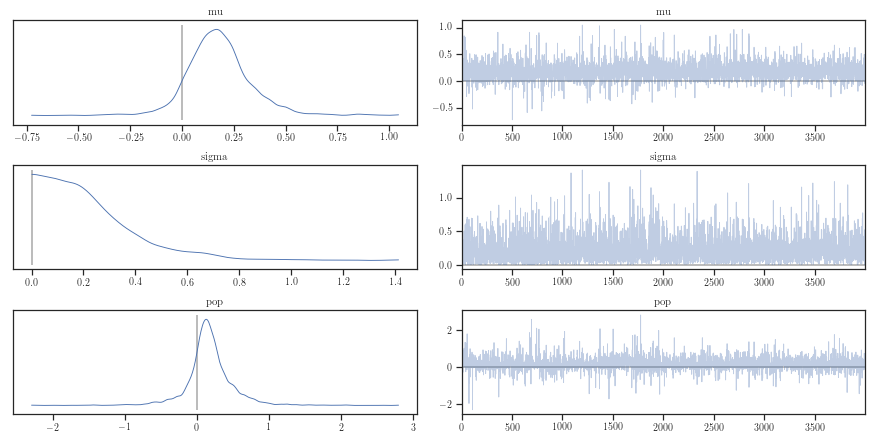

In [157]:
fit = fits_dict['pseob']['dtau_220']
truth_lines = [(k, {}, 0) for k in ['mu', 'sigma', 'pop']]
az.plot_trace(fit, lines=truth_lines);

In [158]:
def get_label(k):
    p = k.split('_')[0][1:].replace('omega', 'f').replace('tau', r'\tau')
    lmn = k.split('_')[1]
    return r'$\delta %s_{%s}$' % (p, lmn)

/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


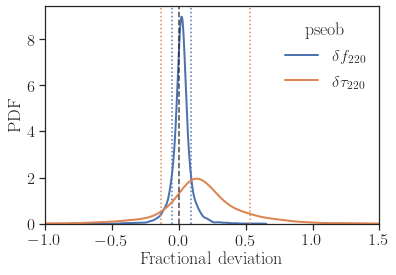

In [159]:
for run, fits in fits_dict.items():
    xlim = [-1,1.5]
    for i, param in enumerate(params_dict[run]):
        c = sns.color_palette()[i]
        l = get_label(param)
        x = fits[param]['pop']
        sns.distplot(x, label=l, hist=False,
                     kde_kws={'gridsize': 500, 'lw': 2},
                     hist_kws={'range': xlim}, color=c)
        gca().axvline(percentile(x, 10), ls=':', c=c)
        gca().axvline(percentile(x, 90), ls=':', c=c)
    gca().axvline(0, c='k', ls='--', alpha=0.8)
    plt.xlim(*xlim)
    plt.xlabel(r'Fractional deviation')
    plt.ylabel('PDF')
    plt.legend(framealpha=0.7, edgecolor='w', title=run)
    plt.show()

## Comparison with O3a

In [160]:
O3adomega220=np.loadtxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/pseob/domega_220_pop.txt.gz')
O3adtau220=np.loadtxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/pseob/dtau_220_pop.txt.gz')

/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


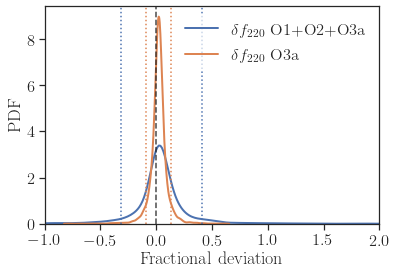

In [161]:
xlim = [-1, 2]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta f_{220}$ O1+O2+O3a'
l1 = r'$\delta f_{220}$ O3a'
x0 = O3adomega220
x1 = fits['domega_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c1)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


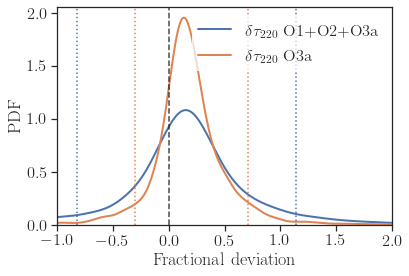

In [162]:
xlim = [-1, 2]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta \tau_{220}$ O1+O2+O3a'
l1 = r'$\delta \tau_{220}$ O3a'
x0 = O3adtau220
x1 = fits['dtau_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c1)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

## Multiplying likelihoods ("restricted combination")

In [164]:
from sklearn.neighbors import KernelDensity

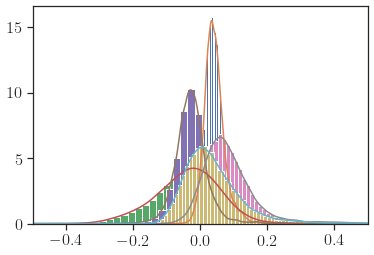

In [165]:
for event in data['domega_220'].keys():

    data0=data['domega_220'][event]

    plt.hist(data0, bns=80,density=True) 
    x =  np.linspace(-1,1,1000)[:, np.newaxis]

    bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
    kde0 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
    log_dens0 = kde0.score_samples(x)

    plt.plot(x,np.exp(log_dens0))

    plt.xlim([-0.5,0.5])

plt.show()

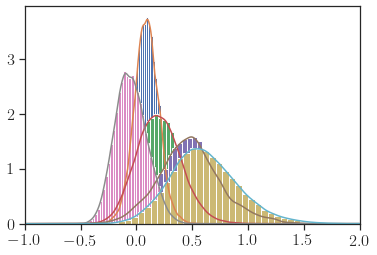

In [196]:
for event in data['dtau_220'].keys():

    data0=data['dtau_220'][event]

    plt.hist(data0, bins=50,density=True) 
    x =  np.linspace(-1,2,1000)[:, np.newaxis]

    bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
    kde0 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
    log_dens0 = kde0.score_samples(x)

    plt.plot(x,np.exp(log_dens0))

    plt.xlim([-1,2])

plt.show()

In [167]:
for event in data['domega_220'].keys():
    
        print(max(data['domega_220'][event]))

0.3054798352621073
1.2809288668320324
1.3725702104318087
0.8235213120481676
0.6665451299920063


In [244]:
x =  np.linspace(-0.9,1.5, 10000)[:, np.newaxis]

log_dens = np.zeros_like(x).T[0] #[0]*len(x)

for event in data['domega_220'].keys():
    
        data0=data['domega_220'][event]
        
        bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
        log_dens += kde.score_samples(x)
    
prob=np.exp(log_dens)
comb_domega220=np.random.choice(x[:,0], 10000,p=prob/(sum(prob)))

In [169]:
for event in data['dtau_220'].keys():
    
        print(max(data['dtau_220'][event]))

0.5681905935480027
1.2588436836700834
1.4960864487371694
0.6342198566132196
2.461509383018356


In [245]:
x =  np.linspace(-0.9,2.5, 10000)[:, np.newaxis]

log_dens = np.zeros_like(x).T[0]

for event in data['dtau_220'].keys():
    
        data0=data['dtau_220'][event]
        
        bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
        log_dens += kde.score_samples(x)

prob=np.exp(log_dens)
comb_dtau220=np.random.choice(x[:,0], 10000,p=prob/(sum(prob)))

/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


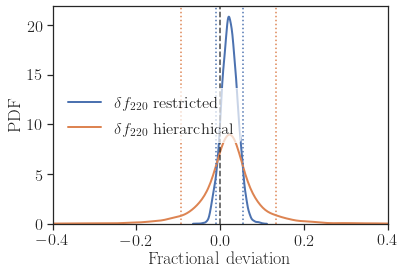

In [246]:
xlim = [-0.4, 0.4]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta f_{220}$ restricted'
l1 = r'$\delta f_{220}$ hierarchical'
x0 = comb_domega220 #fits['domega_220']['pop'][fits['domega_220']['sigma']<0.01]
x1 = fits['domega_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c1)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


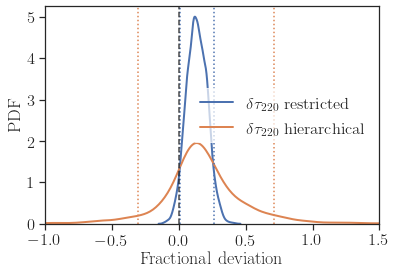

In [247]:
xlim = [-1, 1.5]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta \tau_{220}$ restricted'
l1 = r'$\delta \tau_{220}$ hierarchical'

x0 = comb_dtau220  #fits['dtau_220']['pop'][fits['dtau_220']['sigma']<0.05]
x1 = fits['dtau_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c1)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

In [248]:
ci1, ci2 = utils.ComputeSymCIedges(np.array(comb_domega220))
med = np.median(np.array(comb_domega220))
print('domega_220 (restricted):\t%.2f +%.2f -%.2f\t[%.2f]' % (med, ci1-med, med-ci2, ci1-ci2))

ci1, ci2 = utils.ComputeSymCIedges(np.array(comb_dtau220))
med = np.median(np.array(comb_dtau220))
print('dtau_220 (restricted):\t%.2f +%.2f -%.2f\t[%.2f]' % (med, ci1-med, med-ci2, ci1-ci2))
  

domega_220 (restricted):	0.02 +0.03 -0.03	[0.06]
dtau_220 (restricted):	0.14 +0.13 -0.12	[0.25]


In [254]:
np.savetxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{par}_comb.dat'.format(par='domega_220'),comb_domega220)
np.savetxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{par}_comb.dat'.format(par='dtau_220'),comb_dtau220)


## plotting all together

/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

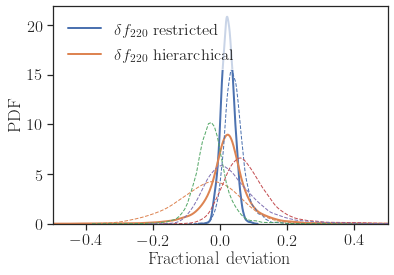

In [249]:
xlim = [-1, 1]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta f_{220}$ restricted'
l1 = r'$\delta f_{220}$ hierarchical'
x0 = comb_domega220
x1 = fits['domega_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c1)

for event in data['domega_220'].keys():

    data0=data['domega_220'][event]

    sns.distplot(data0, hist=False,kde_kws={'lw': 1,'linestyle':'--'}) 

plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w',loc='upper left')
plt.xlim([-0.5,0.5])
plt.show()

/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/anaconda/envs/spinqnm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

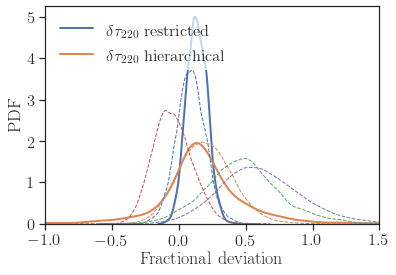

In [250]:
xlim = [-1, 1.5]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta \tau_{220}$ restricted'
l1 = r'$\delta \tau_{220}$ hierarchical'
x0 = comb_dtau220
x1 = fits['dtau_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c1)

for event in data['dtau_220'].keys():

    data0=data['dtau_220'][event]

    sns.distplot(data0, hist=False,kde_kws={'lw': 1,'linestyle':'--'}) 

plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w',loc='upper left')
plt.xlim([*xlim])
plt.show()